In [3]:
import numpy as np 
from sklearn import datasets
from scipy.cluster.hierarchy import ward, fcluster
from scipy.stats import multivariate_normal
from scipy.spatial import ConvexHull
from scipy.io import loadmat
import open3d as o3d
import warnings
import matplotlib.pyplot as plt

In [4]:
random_state=71

In [5]:
# create a simple dataset

n_samples = 500
n = 5

X, y = datasets.make_blobs(centers = n, n_features = 3, n_samples=n_samples, random_state=random_state, center_box=(-20.0,20.0))
#transformation = [[1.5, -1, 1], [-1.5, 2, 1], [-1.5, 2, 1]]
#X = np.dot(X, transformation)

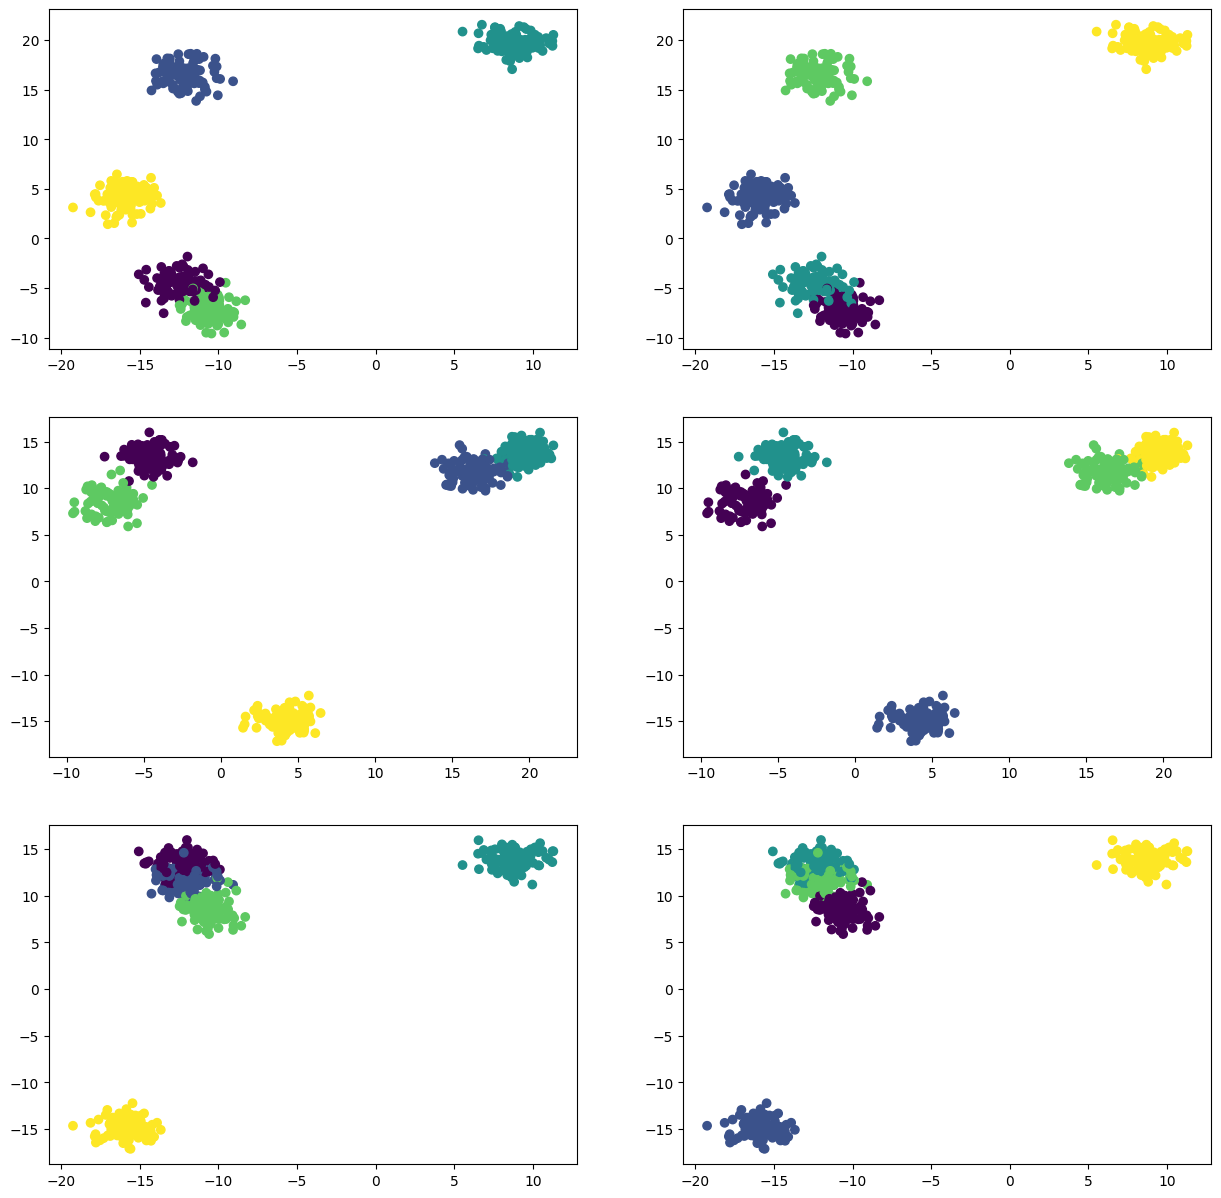

In [196]:
fig, ax = plt.subplots(3,2)
ax[0,0].scatter(X[:,0], X[:,1], c=y)
ax[0,1].scatter(X[:,0], X[:,1], c=labs)
ax[1,0].scatter(X[:,1], X[:,2], c=y)
ax[1,1].scatter(X[:,1], X[:,2], c=labs)
ax[2,0].scatter(X[:,0], X[:,2], c=y)
ax[2,1].scatter(X[:,0], X[:,2], c=labs)

fig.set_figwidth(15)
fig.set_figheight(15)

In [6]:
class KernelParameters:
    '''
    A class to store the kernel parameters of all kernels in the fault network

    mean: np.array
        Array of shape (n_kernels, n_dimensions) that contains the mean for every kernel. 

    cov: np.array
        Array of shape (n_kernels, n_dimensions, n_dimensions) that contains the covariance matrices for every kernel. 
    
    weight: np.array
        Array of shape (n_kernels,) that contains the weight of every kernel.

    bbox: np.array
        An array of shape (n_kernels,8,3) that contains the corners of the bounding box.
    
    is_bkg: np.array
        A boolean array of shape(n_kernels,) that indicates which kernel is a background kernel
    '''

    def __init__(self, n_dim: int = 3):

        self.n_kernels = 0
        self.n_dim = n_dim
        
        self.mean = np.zeros((0,n_dim), dtype=np.float64)
        self.cov = np.zeros((0,n_dim,n_dim), dtype=np.float64)
        self.weight = np.zeros((0,), dtype=np.float64)
        self.bbox = np.zeros((0,2**n_dim,n_dim), dtype=np.float64)
        self.is_bkg = np.zeros((0,), dtype=bool)
    
    def get_dim(self):
        return self.n_dim
    
    def get_n_kernels(self):
        return self.n_kernels
    
    def add_kernels(self, mean, cov, weight, bbox, is_bkg):
        '''Add new kernels to the kernel configuration'''

        self.mean = np.concatenate([self.mean, mean], axis=0)
        self.cov = np.concatenate([self.cov, cov], axis=0)
        self.weight = np.concatenate([self.weight, weight], axis=0)
        self.bbox = np.concatenate([self.bbox, bbox], axis=0)
        self.is_bkg = np.concatenate([self.is_bkg, is_bkg], axis=0)

        self.n_kernels += len(weight)

    def concatenate_parameters(self, kernelp):
        '''Add new kernels from another KernelParameters object'''

        self.add_kernels(kernelp.mean, kernelp.cov, kernelp.weight, kernelp.bbox, kernelp.is_bkg)
    
    def modify_kernels(self, kernel_idx, mean, cov, weight, bbox, is_bkg):
        '''
        Modify a single or multiple existing kernels in the kernel configuration.
        Make sure that the type of kernel_idx and the shape of the other arguments match.
        '''

        self.mean[kernel_idx] = mean
        self.cov[kernel_idx] = cov
        self.weight[kernel_idx] = weight
        self.bbox[kernel_idx] = bbox
        self.is_bkg[kernel_idx] = is_bkg
    
    def modify_weight(self, weight):
        '''
        Modify the weights of all kernels in the kernel configuration
        '''

        if self.weight.shape != weight.shape:
            raise ValueError('Input weight matrix must have same shape as current weight matrix')

        self.weight = weight

    def get(self, field: str):
        '''
        Get a specific field from the kernel parameters.
        '''

        if field == 'm':
            return self.mean
        elif field == 'c':
            return self.cov
        elif field == 'w':
            return self.weight
        elif field == 'b':
            return self.bbox
        elif field == 'ib':
            return self.is_bkg
        else:
            raise ValueError(f'Unknown field {field}')
    
    def delete_kernels(self, kernel_idx):
        '''
        Remove a single or multiple kernels from the kernel configuration.

        Parameters
        -----------
        kernel_idx: int | array_like
            Integer, an integer index or a boolean mask of length n_kernels that indicates which kernels to keep

        '''

        if hasattr(kernel_idx, "__len__") and isinstance(kernel_idx[0], (bool, np.bool_)):
            self.mean = self.mean[kernel_idx]
            self.cov = self.cov[kernel_idx]
            self.weight = self.weight[kernel_idx]
            self.bbox = self.bbox[kernel_idx]
            self.is_bkg = self.is_bkg[kernel_idx]

            self.n_kernels = sum(kernel_idx)

        else:
            self.mean = np.delete(self.mean, kernel_idx, axis=0)
            self.cov = np.delete(self.cov, kernel_idx, axis=0)
            self.weight = np.delete(self.weight, kernel_idx, axis=0)
            self.bbox = np.delete(self.bbox, kernel_idx, axis=0)
            self.is_bkg = np.delete(self.is_bkg, kernel_idx, axis=0)

            self.n_kernels -= len(kernel_idx) if hasattr(kernel_idx, "__len__") else 1
    
    def get_kernels(self, kernel_idx = None):
        '''
        Extract the kernel parameters of a single or multiple kernels.
        If kernel_idx = None, return all kernels. 
        If kernel_idx is an integer, the outer dimension of the return values is flattened.
        '''

        if kernel_idx is None:
            kernel_idx = range(self.n_kernels)

        return self.mean[kernel_idx], self.cov[kernel_idx], self.weight[kernel_idx], self.bbox[kernel_idx], self.is_bkg[kernel_idx]


In [166]:
def get_capacity_clusters(X: np.array, 
                          min_sz_cluster: int = 4, 
                          min_n_merges: int = 4
                          )->np.array:
    '''
    Get the cluster assignment with the largest number of valid clusters based on ward linkage.
    Iteratively cuts the tree from the bottom until the number of valid clusters does not increase anymore.
    
    Parameters
    -----------
    X: np.array
        The data to compute the cluster assignment for as an array of size (n_samples x n_dimensions)
    
    min_sz_cluster: int
        The threshold on the cluster size for a cluster to be considered valid, default = 4

    min_n_merges: int
        The number of cluster merging steps that can be skipped by the algorithm, default = 4


    Returns
    --------
    capacity_labels: np.array
        The cluster labels as an array of length n_samples
    '''

    min_n_merges = max(min_sz_cluster, min_n_merges)

    link_tree = ward(X)

    capacity = 0
    capacity_labels = np.zeros(len(X))
    prev = [0,0]

    for n_branch in range(1,len(link_tree)):

        # get cluster labels and determine the cluster sizes
        labels = fcluster(link_tree, link_tree[len(link_tree)-n_branch, 2], "distance")-1
        _ , counts = np.unique(labels, return_counts = True)
        
        n_clusters = sum(counts >= min_sz_cluster)

        # check whether capacity has improved
        if n_clusters >= capacity:
            capacity = n_clusters
            capacity_labels = labels
        
        # stop when the number of clusters drops
        elif n_clusters < prev[0] and n_clusters < prev[1]:
            break

        prev.pop()
        prev.insert(n_clusters, 0)

    return capacity_labels


In [7]:
def fit_gaussian_kernels(X: np.array,
                         cluster_labels: np.array,
                         min_sz_cluster: int = 4
                         )->tuple:
    '''
    Fit a Gaussian kernel to every valid cluster. Fits mean, covariance and weight for every kernel.
    If there are points that are not in any valid cluster, fit a uniform background kernel.

    Parameters
    -----------
    X: np.array
        An array of observations. Must be of shape (n_samples, n_dimensions).
    
    cluster_labels: np.array
        The cluster assignment of every observation. Must be of length n_samples
    
    min_sz_cluster: int
        The threshold on the cluster size for a cluster to be considered valid, default = 4

    Returns
    -------
    kernels: KernelParameters
        The kernel configuration after fitting Gaussian kernels to valid clusters

    '''

    if len(X) != len(cluster_labels):
        raise ValueError(f'Number of datapoints {len(X)} does not match number of labels {len(cluster_labels)}')
    
    # determine dataset parameters
    n_dim = X.shape[1]
    n_points = X.shape[0]
    uq_clusters, cluster_szs = np.unique(cluster_labels, return_counts = True) # all clusters and sizes
    n_clusters = sum(cluster_szs >= min_sz_cluster) # number of valid clusters
    valid_clusters = uq_clusters[cluster_szs >= min_sz_cluster] # labels of valid clusters
    fit_background = n_clusters < len(uq_clusters)

    mean = np.zeros((n_clusters+int(fit_background), n_dim))
    covar = np.repeat([np.eye(n_dim)], n_clusters+int(fit_background), axis=0)
    weight = np.zeros(n_clusters+int(fit_background))
    bbox = np.full((n_clusters+int(fit_background), 8, 3), np.nan)
    is_bkg = np.full(n_clusters+int(fit_background), False)

    for i in range(n_clusters):

        id = valid_clusters[i]
        X_curr = X[cluster_labels == id] 

        # compute cluster mean
        mean[i,:] = np.mean(X_curr, axis=0)

        # compute cluster covariance
        covar[i,:,:] = np.cov(X_curr, rowvar=False)

        # compute cluster weight
        weight[i] = len(X_curr)/n_points
    
    if fit_background and n_dim == 3:
        # fit the background kernel

        bbox[-1,:,:], mean[-1,:] = get_minimum_bbox(X)
        is_bkg[-1] = True

        # compute background covariance
        covar[-1,:] = np.cov(bbox[-1,:,:], rowvar=False)*3.5 

        # compute background weight
        weight[-1] = sum([l not in valid_clusters for l in cluster_labels])/n_points
        
    kernels = KernelParameters()
    kernels.add_kernels(mean, covar, weight, bbox, is_bkg)


    return kernels

        

def get_minimum_bbox(X: np.ndarray)->tuple:

    '''
    Calculate the minimum volume oriented bounding box for the points in X

    Parameters
    -----------
    X: np.array
        An array containing a point cloud of observations. Has to be of shape (n_samples, 3)

    Returns
    --------
    corners: np.array
        The 8 corner points of the bounding box as an array of shape (8,3)

    center: np.array
        The center point of the bounding box as an array of shape (3,)
    
    '''

    if X.shape[1] != 3:
        raise ValueError(f'Data has to be 3-dimensional, was {X.shape[1]}-dimensional')

    # create a point cloud object from the data
    cloud = o3d.geometry.PointCloud()
    cloud.points = o3d.utility.Vector3dVector(X)

    # get the corners and center of the minimum bounding box
    bbox = cloud.get_minimal_oriented_bounding_box()

    corners = np.asarray(bbox.get_box_points())
    center = bbox.get_center()

    return corners, center


def get_gaussian_bbox(mean: np.ndarray,
                      cov: np.ndarray,
                      n_var: float)->tuple:
    '''
    Calculate the minimum volume oriented bounding box for the points within sqrt(n_var) standard deviations of the mean of a 3D-Gaussian.

    Parameters
    ----------

    mean: np.array
        Mean vector of the Gaussian. Must be of shape (3,).
    
    cov: np.array
        Covariance matrix of the Gaussian. Must be of shape (3,3).
    
    n_var: float
        How many variances from the mean of the Gaussian to consider for the bounding box.

    Returns
    --------

    corners: np.array
        The 8 corner points of the bounding box as an array of shape (8,3)

    mean: np.array
        The center point of the bounding box as an array of shape (3,). Is equivalent to mean vector of the Gaussian.

    '''

    if mean.shape != (3,) or cov.shape != (3,3):
        raise ValueError('Gaussian must be 3-dimensional')
    
    evals, evecs = np.linalg.eigh(n_var*cov)

    # determine lengths of the bbox edges
    l_sides = 0.5*np.sqrt(evals) 
    
    # get an unrotated cuboid centered around 0 of the correct size
    corners = np.array([[-1, 1, 1, -1, -1, 1, 1, -1],
                        [1, 1, 1, 1, -1, -1, -1, -1],
                        [-1, -1, 1, 1, 1, 1, -1, -1]], dtype=np.float64)
    corners *= np.expand_dims(l_sides, axis=1)
    
    # rotate and shift the cuboid to the correct position and get the correct shape
    corners = (evecs @ corners).T + np.tile(mean, [8,1])

    return corners, mean 

In [6]:

def inhull(X: np.array,
           hull_pts: np.array,
           eps: float = np.finfo(float).eps
          )->np.array:
  
  '''
  Check for all points in X whether they lie in the convex hull defined by hull_pts.
  Adapted from https://stackoverflow.com/questions/31404658/check-if-points-lies-inside-a-convex-hull

  Parameters
  -----------
  X: np.array
    An array of observations. Must be of shape (n_samples, n_dimensions).
  
  hull_pts: np.array
    An array of points from which the convex hull is determined. Must be of shape (n_points, n_dimensions).
  
  eps: np.float32
    The tolerance to be used when checking whether a given point is inside the hull.
    Choose > 0 to avoid numerical issues, default = np.finfo(float).eps

  Returns
  --------
  in_hull: np.array
    A boolean array of shape (n_samples,) indicating which points in X are inside the hull
    
  '''

  if X.shape[1] != hull_pts.shape[1]:
    raise ValueError(f'Hull points and test points must have the same dimensions.')
  
  hull = ConvexHull(hull_pts)

  # A is shape (f, d) and b is shape (f, 1).
  A, b = hull.equations[:, :-1], hull.equations[:, -1]

  # The hull is defined as all points x for which Ax + b <= 0.
  in_hull = np.array([np.all(A @ x + b < eps) for x in X])

  return in_hull

In [163]:
def assign_to_kernel(X: np.array,
                     kernels: KernelParameters,
                     min_sz_cluster: int = 4,
                     refit_gauss: bool = False,
                     refit_bbox: bool = True
                     ):
    '''
    Perform a single step of expectation maximization to assign each data point to its kernel.
    Assigns each point to the most likely kernel and then updates the kernels.

    Parameters
    ----------
    X: np.ndarray
        An array of observations. Must be of shape (n_samples, n_dimensions).

    kernels: KernelParameters
        The current kernel configuration
    
    min_sz_cluster: int
        The threshold on the cluster size for a cluster to be considered valid, default = 4

    refit_gauss: bool
        Indicates whether the mean and covariance of non-background kernels should be refitted, default = False

    refit_bbox: bool
        Indicates whether the bounding box of non-background kernels should be refitted, default = True
        
    Returns
    --------
    kernels: KernelParameters
        The updated kernel configuration
    
    k_assign: np.ndarray
        An array of shape (n_samples,) which indicates the kernel assignment of every point in X

    kernel_prob: np.ndarray
        An array of shape (n_samples, n_kernels) that contains the probability of each datapoint under each kernel
    '''

    n_points = len(X)

    # assign each data point to most likely kernel
    kernel_prob = get_kernel_prob(X, kernels)
    k_assign = np.argmax(kernel_prob, axis=1)

    del_ker = []

    for i in range(kernels.get_n_kernels()):

        msk = k_assign == i
        cluster_sz = sum(msk)
        mean, cov, weight, bbox, is_bkg = kernels.get_kernels(i)

        if cluster_sz >= min_sz_cluster or (is_bkg and cluster_sz > 0):
            
            if not is_bkg:

                if refit_gauss:
                    # update kernel parameters
                    cov = np.cov(X[msk,:], rowvar=False)
                    mean = np.mean(X[msk,:], axis=0)

                if refit_bbox:
                    # bbox defined by the points in the cluster
                    bbox_pts, _ = get_minimum_bbox(X[msk,:])

                    # bbox defined by the Gaussian kernel
                    bbox_gauss, _ = get_gaussian_bbox(mean, cov, 12)

                    # bbox is minimum bbox of the union of all corner points
                    bbox, _ = get_minimum_bbox(np.concatenate((bbox_pts, bbox_gauss), axis=0))
            
            weight = cluster_sz / n_points
            kernels.modify_kernels(i, mean, cov, weight, bbox, is_bkg)

        else:
    
            del_ker.append(i)

    # delete non-background kernels with too few points
    if len(del_ker) > 0:
        print(f"  Removed {len(del_ker)}/{kernels.get_n_kernels()} kernels with < {min_sz_cluster} points")
        kernels.delete_kernels(del_ker)

    # update probabilities and kernel assignment
    kernel_prob = get_kernel_prob(X, kernels)
    k_assign = np.argmax(kernel_prob, axis=1)

    return kernels, k_assign, kernel_prob



def get_kernel_prob(X: np.ndarray,
                     kernels: KernelParameters
                     ):
    '''
    Determine the probability of each data point under each kernel

    Parameters
    ----------
    X: np.ndarray
        An array of observations. Must be of shape (n_samples, n_dimensions).

    kernels: KernelParameters
        The current kernel configuration
        

    Returns
    --------
    kernel_prob: np.array
        An array of shape (n_samples, n_kernels)
    '''

    kernel_prob = np.zeros((len(X), kernels.get_n_kernels()), dtype=np.float64)

    # calculate the the probability of each point under each kernel
    for i in range(kernels.get_n_kernels()):

        mean, cov, weight, bbox, is_bkg = kernels.get_kernels(i)

        if not is_bkg:
            
            p = multivariate_normal(mean=mean, cov=cov).pdf(X)

            if hasattr(p, '__len__'):
                p[p < np.finfo(np.float64).eps] = np.finfo(np.float64).eps
                
            elif p < np.finfo(np.float64).eps:
                p = np.finfo(np.float64).eps

            kernel_prob[:,i] = weight * p
    
        else:
            # determine points in background kernel
            eps = 1e-10*np.mean(np.abs(bbox))
            bkg_pts = inhull(X, bbox, eps)
            
            # calculate probability of being in the background
            kernel_prob[bkg_pts,i] = weight/np.prod(np.sqrt(np.linalg.eigvalsh(cov)), axis=0)

    return kernel_prob


def get_bic(kernel_prob: np.ndarray,
            n_kernels: int = None):
    '''
    Calculate the Bayesian Information Criterion of the dataset from the probability of each datapoint under each kernel

    Parameters
    ----------
    kernel_prob: np.array
        An array of shape (n_samples, n_kernels) that contains the probability of every sample under every kernel
    
    n_kernels: int
        Optional number of kernels to use. Can be specified if kernel_prob is already a cumulative probability, default = None
    
    Returns
    --------
    bic: float
        The BIC value of the current kernel configuration
    '''
    
    n_points = kernel_prob.shape[0]
    
    if n_kernels is None:
        n_kernels = kernel_prob.shape[1]

    # get cumulative probability per data point
    total_prob = np.sum(kernel_prob, axis = 1)

    res_msk = total_prob < np.finfo(np.float64).eps
    if sum(res_msk) > 0:
        total_prob[res_msk] = np.finfo(np.float64).eps
        warnings.warn('Reached probability density resolution limit')

    # calculate BIC
    bic = np.sum(-np.log(total_prob))+0.5*(10*n_kernels-1)*np.log(n_points)

    return bic

In [202]:
def have_overlap(bbox1: np.array,
                 bbox2: np.array):
    '''
    Check whether two bounding boxes overlap.

    Parameters
    ----------
    bbox1: np.array
        The corner points of the first bounding box as an array of shape (n_points, n_dimensions)
    
    bbox1: np.array
        The corner points of the second bounding box as an array of shape (n_points, n_dimensions)
    
    Returns
    --------
    overlap: bool
        Indicates whether the two bounding boxes overlap

    '''
    
    overlap = np.any(inhull(bbox1, bbox2)) or np.any(inhull(bbox2, bbox1))

    return overlap



def merge_single_pair(kernel_pair: KernelParameters,
                      keep_wgt: bool = True):
    '''
    Perform a Gaussian merge on a pair of kernels

    Parameters
    ----------
    kernel_pair: KernelParameters
        Contains the two kernels for which the merged kernel should be computed
    
    keep_wgt: bool
        Indicates whether to compute the weight of the merged kernel or set it to 1, default = True

    Returns
    --------
    mean: np.ndarray
        The mean vector of the merged kernel, has shape (1, n_dim)
    
    cov: np.ndarray
        The covariance matrix of the merged kernel, has shape (1, n_dim, n_dim)
    
    weight: np.ndarray
        The weight of the merged kernel, has shape (1,)
    
    bbox: np.ndarray
        The bounding box of the merged kernel, has shape(1, 2**n_dim, n_dim)
    
    is_bkg: np.ndarray
        Indicates whether the merged kernel is a background kernel, has shape (1,)

    '''
    if kernel_pair.get_n_kernels() != 2:
        raise ValueError('Kernel configuration is not a pair')

    # unpack the kernel parameters
    m1, c1, w1, b1, ib1 = kernel_pair.get_kernels(0)
    m2, c2, w2, b2, ib2 = kernel_pair.get_kernels(1)
    
    # calculate merged bbox and weight
    weight = w1+w2
    bbox, center = get_minimum_bbox(np.concatenate([b1,b2], axis=0))
    is_bkg = ib1 or ib2

    # calculate new mean and covariance
    if is_bkg:
        mean = center
        cov = np.cov(bbox, rowvar=False)*3.5
    
    else:
        mean = 1/weight * (w1 * m1 + w2 * m2)
        cov = (w1/weight)*(c1 + np.outer((m1-mean),(m1-mean))) + (w2/weight)*(c2 + np.outer((m2-mean),(m2-mean)))


    if not keep_wgt:
        weight = 1

    return np.array([mean]), np.array([cov]), np.array([weight]), np.array([bbox]), np.array([is_bkg])



def get_disjoint_pairs(rows: np.ndarray,
                       cols: np.ndarray,
                       score: np.ndarray):
    '''
    Get the disjoint pairs from a set of row-column index pairs.
    The first occurrence of an index is decided based on descending score.

    Parameters
    -----------
    rows: np.array
        An array of row indices
    
    cols: np.array
        An array of column indices in the same order as rows
    
    score: np.array
        An array of scores that determine the precedence of a pair in the same order as rows.
        Higher score is better and pairs with non-positive scores are cut.
    
    Returns
    -------
    rows, columns, score: np.array
        The row and column indices and scores of the unique pairs sorted by descending score
    
    idx_sort: np.array
        An index that can be used to extract the matching elements of an array with the same order
        as the input rows or columns
    '''

    # get all pairs with improvement
    idx_imp = score > 0

    if sum(idx_imp) < len(idx_imp):
        print(f'  Removed {sum(~idx_imp)}/{len(idx_imp)} pairs with negative information gain')

    rows = rows[idx_imp]
    cols = cols[idx_imp]
    score = np.array(score)[idx_imp]
    
    # sort the pairs by descending score
    idx_sort = np.argsort(score)[::-1]
    rows = rows[idx_sort]
    cols = cols[idx_sort]

    del_idx = []
    unique_rows = []
    unique_cols = []

    # only keep disjoint pairs
    for i in range(len(score)):
        if (rows[i] in unique_rows+unique_cols) or (cols[i] in unique_cols+unique_rows):
            del_idx.append(False)
        else:
            del_idx.append(True)
            unique_rows.append(rows[i])
            unique_cols.append(cols[i])

    return np.array(unique_rows), np.array(unique_cols), score[del_idx], idx_sort[del_idx]


def merge_kernel_assignment(kernel_assign: np.ndarray,
                            kernel1: np.ndarray, 
                            kernel2: np.ndarray,
                            n_old_kernels: int = None):
    
    '''
    Map the old kernel labels to the new kernel labels.
    Kernel labels coincide with position of the kernel in the KernelParameters object.

    Parameters
    -----------
    kernel_assign: np.ndarray
        The old kernel assignment of every data point. Has shape (n_samples,)
    
    kernel1, kernel2: np.ndarray
        Contain the labels of the first and second kernel of every merged pair in the same order

    n_old_kernels: int | None
        Manually specify the number of kernels before the merging. Needed if there are some kernels without any points assigned to them.
        If None, the number of kernels is inferred from the kernel assignment.


    Returns
    --------
    kernel_assign: np.ndarray
        The new kernel assignment of ever data point

    '''
    if n_old_kernels is None:
        n_old_kernels = len(np.unique(kernel_assign))

    # create a mapping from old kernel labels to new kernel labels
    old2new = np.arange(n_old_kernels)
        
    msk_keep = np.full(len(old2new), True)
    msk_keep[np.concatenate([kernel1, kernel2])] = False

    # add new labels of the old kernels 
    old2new = old2new[msk_keep]
    old2new = dict(zip(old2new, range(len(old2new))))

    n_old = len(old2new)

    # add new labels of the merged kernels
    for i in range(len(kernel1)):

        old2new[kernel1[i]] = n_old+i
        old2new[kernel2[i]] = n_old+i

    kernel_assign = np.array([old2new[l] for l in kernel_assign])

    return kernel_assign


def merge_clusters(X: np.ndarray,
                   kernels: KernelParameters,
                   kernel_assign: np.ndarray,
                   init_prob: np.ndarray,
                   gain_mode: str = 'global'):
    
    '''
    Merge clusters iteratively 
    '''

    modes = ['local', 'global']

    if gain_mode not in modes:
        raise ValueError(f'Unknown gain mode {gain_mode}. Must be one of {modes}.')

    bic_init = get_bic(init_prob)
    tot_prob_init = np.sum(init_prob, axis=1, keepdims=True)
    n_points = len(X)

    gain = np.zeros((kernels.get_n_kernels(),kernels.get_n_kernels()), dtype=np.float64)

    its = 0

    while True:

        # get indices of all relevant kernel pairs
        rows,cols = np.mask_indices(len(gain), lambda x,k: np.logical_and(np.triu(x,k),~np.isnan(gain)),1)
        
        # check whether pairs are merging candidates
        del_idx = np.full((len(rows)), False)
        for idx, (r, c) in enumerate(zip(rows,cols)):

            _, __, ___, r_bbox, r_bkg = kernels.get_kernels(r)
            _, __, ___, c_bbox, c_bkg = kernels.get_kernels(c)

            del_idx[idx] = r_bkg or c_bkg

            if not del_idx[idx]:
                del_idx[idx] = not have_overlap(r_bbox, c_bbox)
        
        # remove all non-candidates
        gain[rows[del_idx],cols[del_idx]] = np.nan
        gain[cols[del_idx],rows[del_idx]] = np.nan

        rows = rows[~del_idx]
        cols = cols[~del_idx]
        
        if len(rows)==0:
            print('  No pairs with overlapping bbox')
            break


        new_kernels = KernelParameters()
        p_merged = []
        p_separate = []
        merge_score = []

        for idx, (r, c) in enumerate(zip(rows,cols)):

            # get the pair kernels
            old_kerns = KernelParameters()
            old_kerns.add_kernels(*kernels.get_kernels([r,c]))

            new_kern = KernelParameters()
                
            if gain_mode == 'local':
                
                # only consider contributions from points assigned to the kernel pair
                X_local = X[np.logical_or(kernel_assign == r, kernel_assign == c)]

                # calculate parameters of the merged kernel
                new_kern.add_kernels(*merge_single_pair(old_kerns, keep_wgt = False))

                # get probability and bic under the merged kernel
                prob_merged = get_kernel_prob(X_local, new_kern)
                bic_merged = get_bic(prob_merged)

                # modify weight
                old_kerns.modify_weight(np.array([sum(kernel_assign==r),sum(kernel_assign==c)], dtype=np.float64)/len(X_local))

                # get probability and bic under the two separate kernels
                prob_separate = get_kernel_prob(X_local, old_kerns)
                bic_separate = get_bic(prob_separate)
                
                # calculate the information gain from merging
                merge_score.append(bic_separate-bic_merged)
        
        
            else:
                # calculate parameters of the merged kernel
                new_kern.add_kernels(*merge_single_pair(old_kerns, keep_wgt = True))

                # get cumulative probability under the merged kernel
                tot_prob_merged = np.sum(get_kernel_prob(X, new_kern), axis=1, keepdims=True)
                p_merged.append(tot_prob_merged)

                # get cumulative probability under the two separate kernels
                tot_prob_separate = np.sum(get_kernel_prob(X, old_kerns), axis=1, keepdims=True)
                p_separate.append(tot_prob_separate)
                
                # calculate the cumulative probability after merging and bic
                sum_tot_prob = tot_prob_init - tot_prob_separate + tot_prob_merged
                bic_merged = get_bic(sum_tot_prob, n_kernels = kernels.get_n_kernels()-1)

                # calculate the information gain from merging
                merge_score.append(bic_init-bic_merged)

                # save the new kernel
                new_kernels.concatenate_parameters(new_kern)
    
        if np.nanmax(merge_score) <= 0:
            
            print('  No pairs with information gain')
            break

        msk_sort = np.full(len(rows), False)

        # get unique pairs
        rows, cols, merge_score, idx_sort = get_disjoint_pairs(rows, cols, np.array(merge_score))
        n_pairs = len(rows)


        # merge unique pairs
        if gain_mode == 'local':

            # merge clusters with global method
            p_merged = np.zeros((n_points, 1))
            p_separate = np.zeros((n_points, 1))
            
            for r,c in zip(rows, cols):

                # get the pair kernels
                old_kerns = KernelParameters()
                old_kerns.add_kernels(*kernels.get_kernels([r,c]))
                
                # calculate parameters of the merged kernel
                new_kern = KernelParameters()
                new_kern.add_kernels(*merge_single_pair(old_kerns, keep_wgt = True))

                # get cumulative probability under the merged kernel
                p_merged += np.sum(get_kernel_prob(X, new_kern), axis=1, keepdims=True)

                # get cumulative probability under the two separate kernels
                p_separate += np.sum(get_kernel_prob(X, old_kerns), axis=1, keepdims=True)
                
                new_kernels.concatenate_parameters(new_kern)
            
        else:

            # transform sort index to boolean mask to use on KernelParameters
            msk_sort[idx_sort] = True

            # can reuse results from above
            new_kernels.delete_kernels(msk_sort)
            p_merged = sum(np.array(p_merged)[msk_sort])
            p_separate = sum(np.array(p_separate)[msk_sort])

        # update the initial probability and get the bic of all the merging events
        tot_prob_init = tot_prob_init - p_separate + p_merged
        bic_init = get_bic(tot_prob_init, n_kernels=kernels.get_n_kernels()-new_kernels.get_n_kernels())

        if np.isinf(bic_init):
            print('  Invalid BIC detected')
            break

        # modify kernel assignment
        if gain_mode == 'local':
            kernel_assign = merge_kernel_assignment(kernel_assign, rows, cols, kernels.get_n_kernels())

        # delete the now merged kernels
        idx_del = np.concatenate([rows, cols], axis=0)
        kernels.delete_kernels(idx_del)

        # add the new kernels
        kernels.concatenate_parameters(new_kernels)
            
        gain = np.zeros((kernels.get_n_kernels(),kernels.get_n_kernels()), dtype=np.float64)

        print(f'  Merged {n_pairs} pairs  >> {kernels.get_n_kernels()} kernels left')
        its+=1

    print(f'  Merging terminated after {its} iterations')    
    return kernels, kernel_assign



In [200]:
def cut_chunks(X: np.ndarray,
               n_chunks: int):
    '''
    Cut X into n_chunks chunks based on its agglomerative tree

    Parameters
    ----------
    X: np.ndarray
        An array of observations. Must be of shape (n_samples, n_dimensions).
    
    n_chunks: int
        The number of chunks that the data should be cut into


    Returns
    --------
    chunk_labs: np.ndarray
        An array of shape (n_samples,) that contains the chunk assignment of each datapoint
    '''

    if n_chunks == 1:
        chunk_labs = np.zeros(len(X))
    
    else:
        # compute the labels from the agglomerative link tree
        link_tree = ward(X)
        chunk_labs = fcluster(link_tree, link_tree[-n_chunks, 2], "distance")-1

    return chunk_labs



def run_fault_reconstruction(X: np.ndarray,
                       min_sz_cluster: int,
                       n_chunks: int = 1,
                       gain_mode: str = 'global'
                       ):
    '''
    Run the fault reconstruction algorithm (Kamer 2020)
    
    Parameters
    -----------
    X: np.ndarray
        The data to compute the cluster assignment for as an array of size (n_samples x n_dimensions)
    
    min_sz_cluster: int
        The threshold on the cluster size for a cluster to be considered valid, default = 4

    n_chunks: int
        Number of chunks that the data is cut into before performing the algorithm, default = 1
    
    gain_mode: str
        The method to use for determining the information gain of a merging event, default = 'global'

    Returns
    --------
    all_kernels: np.ndarray
        The cluster assignment of every data point
    
    all_labels: np.ndarray
        The cluster assignment of every data point
    '''

    n_points = len(X)

    # get the chunk partition
    chunk_labs = cut_chunks(X, n_chunks)

    all_kernels = KernelParameters()
    all_labels = np.empty(0, dtype=int)
    lab_offset = 0

    for chunk_id in range(n_chunks):

        msk = chunk_labs == chunk_id

        print(f'Processing chunk {chunk_id+1}/{n_chunks} with {sum(msk)} points')

        # get the capacity clusters based on the agglomerative tree
        capacity_labs = get_capacity_clusters(X[msk], min_sz_cluster)

        # fit the kernels
        kernels = fit_gaussian_kernels(X[msk], capacity_labs, min_sz_cluster)

        print(f'  Fit {sum(~kernels.get("ib"))} Gaussian and {sum(kernels.get("ib"))} background kernels')

        # assign points and update kernels with EM
        kernels, cluster_labs, kernel_prob = assign_to_kernel(X[msk], kernels, min_sz_cluster, refit_gauss = False)
        #print(np.max(kernels.weight), np.min(kernels.weight))
        #print(kernels.mean[np.argmin(kernels.weight)], kernels.cov[np.argmin(kernels.weight)])
        #raise ValueError()
        # run the kernel merging algorithm
        kernels, cluster_labs = merge_clusters(X[msk], kernels, cluster_labs, kernel_prob, gain_mode)

        # reassign the points with EM
        kernels, cluster_labs, kernel_prob = assign_to_kernel(X[msk], kernels, min_sz_cluster)

        print(f'  Merged capacity kernels into {kernels.get_n_kernels()} kernels')

        # shift and persist the cluster labels of the current chunk
        cluster_labs = cluster_labs + lab_offset
        lab_offset += kernels.get_n_kernels()
        all_labels = np.concatenate([all_labels, cluster_labs], axis=0)

        # scale the kernel weights
        kernels.modify_weight(kernels.get('w')*sum(msk)/n_points)

        # persist the kernels of the current chunk
        all_kernels.concatenate_parameters(kernels)
    

    # merge the kernels of all chunks
    print('Combine results of all chunks')
    #kernel_prob = get_kernel_prob(X, all_kernels)
    #all_kernels, all_labels = merge_clusters(X, all_kernels, all_labels, kernel_prob, gain_mode)
    print(f'Final number of kernels: {all_kernels.get_n_kernels()}')

    return all_kernels, all_labels

In [60]:
# read the landers dataset
landers = loadmat('/Users/frederiekelohmann/Documents/FS2024/DSL/DSL_Quake_Fault_Reconstruction/FaultReconAgglo_20201015/landers.mat')

In [201]:
# fault reconstruction on landers dataset
krs, labs = run_fault_reconstruction(landers['xyz_mat'], min_sz_cluster=4, n_chunks=1, gain_mode='global')

Processing chunk 1/1 with 3360 points
  Fit 394 Gaussian and 1 background kernels
  Removed 1/395 kernels with < 4 points
  Merged 121 pairs
  Merged 84 pairs
  Removed 22/508 pairs with negative information gain
  Merged 58 pairs


/var/folders/lz/hqndvh653q79m8xr2wfr4h8r0000gp/T/ipykernel_5892/797128172.py:174: UserWarning: Reached probability density resolution limit
  warnings.warn('Reached probability density resolution limit')


  Removed 238/408 pairs with negative information gain
  Merged 32 pairs
  Removed 241/352 pairs with negative information gain
  Merged 17 pairs
  Removed 229/273 pairs with negative information gain
  Merged 12 pairs
  Removed 188/209 pairs with negative information gain
  Merged 8 pairs
  Removed 159/184 pairs with negative information gain
  Merged 10 pairs
  Removed 97/127 pairs with negative information gain
  Merged 8 pairs
  Removed 56/69 pairs with negative information gain
  Merged 6 pairs
  Removed 26/40 pairs with negative information gain
  Merged 5 pairs
  Removed 11/18 pairs with negative information gain
  Merged 4 pairs
  Removed 7/8 pairs with negative information gain
  Merged 1 pairs
  Removed 6/10 pairs with negative information gain
  Merged 2 pairs
  Removed 4/5 pairs with negative information gain
  Merged 1 pairs
  Removed 7/10 pairs with negative information gain
  Merged 2 pairs
  Removed 4/7 pairs with negative information gain
  Merged 1 pairs
  Removed 2/3

(0.0, 1.0, 0.0, 1.0)

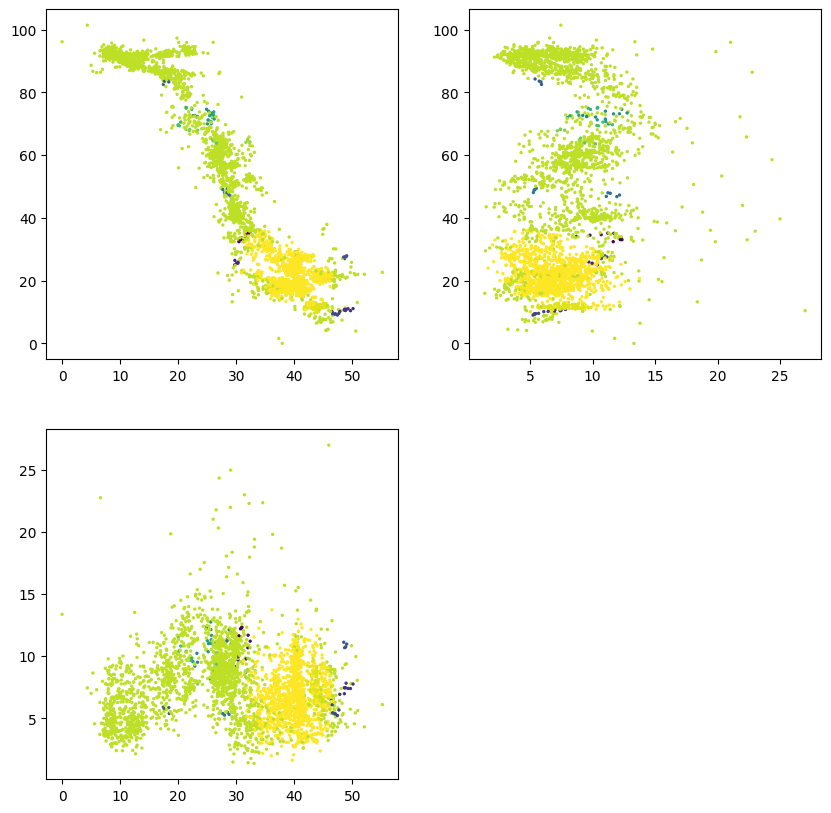

In [190]:
fig, ax = plt.subplots(2,2)
fig.set_figwidth(10)
fig.set_figheight(10)
ax[0,0].scatter(landers['xyz_mat'][:,0], landers['xyz_mat'][:,1], s=2, c=labs)
ax[0,1].scatter(landers['xyz_mat'][:,2], landers['xyz_mat'][:,1], s=2, c=labs)
ax[1,0].scatter(landers['xyz_mat'][:,0], landers['xyz_mat'][:,2], s=2, c=labs)
ax[1,1].axis('off')

In [198]:
# fault reconstruction on simple example dataset
krs, labs = run_fault_reconstruction(X, min_sz_cluster=4, n_chunks=1, gain_mode='global')

Processing chunk 1/1 with 500 points
  Fit 72 Gaussian and 1 background kernels
  Merged 23 pairs
  Merged 14 pairs
  Merged 11 pairs
  Removed 1/29 pairs with negative information gain
  Merged 8 pairs
  Removed 1/17 pairs with negative information gain
  Merged 6 pairs
  Removed 1/6 pairs with negative information gain
  Merged 4 pairs
  Removed 1/2 pairs with negative information gain
  Merged 1 pairs
  No pairs with information gain
  Merging terminated after 7 iterations
  Merged capacity kernels into 6 kernels
Combine results of all chunks
  No pairs with information gain
  Merging terminated after 0 iterations
  Final number of kernels: 6


In [203]:
_, cts = np.unique(labs, return_counts=True)
cts

In [205]:
krs.is_bkg

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
        True, False, False])

### Potential error sources

* bbox calculation


In [8]:
# bboxes obtained with python and matlab on very simple datasets

bbox_py, _ = get_minimum_bbox(X[:5])

bbox_mat =  np.array([[-14.2277,   -5.1252,   12.8868],
    [6.0412,   20.5484,   17.0145],
    [9.4700,   18.4192,   13.4208],
  [-10.7988,   -7.2544,    9.2931],
  [-14.9549,   -4.3673,   11.7438],
    [5.3139,   21.3064,   15.8716],
    [8.7428,   19.1772,   12.2779],
  [-11.5261,   -6.4965,    8.1501]])

In [9]:
sum(inhull(bbox_py, bbox_mat))

0

In [10]:
sum(inhull(bbox_mat, bbox_py))

2

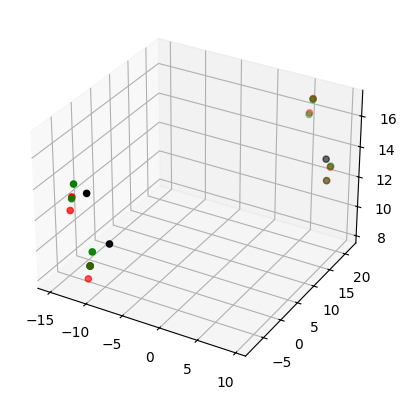

In [28]:
# visualize the bboxes obtained with matlab and python code
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

ax.scatter(X[:5, 0], X[:5, 1], X[:5, 2], c='black')
ax.scatter(bbox_mat[:, 0], bbox_mat[:, 1], bbox_mat[:, 2], c='red')
ax.scatter(bbox_py[:, 0], bbox_py[:, 1], bbox_py[:, 2], c='green')
plt.show()